<a href="https://colab.research.google.com/github/enanpurrp/MHIT/blob/main/MHAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Visualizing geographical and cultural trends in suicide rates**

By: Sachin Chanchani

https://matplotlib.org/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html


In [231]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


Part 1 Setup

In [232]:
# Getting CSVs to DFs
facilities = pd.read_csv('https://raw.githubusercontent.com/enanpurrp/MHIT/main/Facilities.csv')
hr = pd.read_csv('https://raw.githubusercontent.com/enanpurrp/MHIT/main/Human%20Resources.csv')
suicide_rates = pd.read_csv('https://raw.githubusercontent.com/enanpurrp/MHIT/main/Age-standardized%20suicide%20rates.csv')

# Merging DFs
facilities_hr_merged = pd.merge(facilities, hr, on='Country')
facilities_hr_merged.set_index('Country', inplace=True)

# Get rid of extra year column, get rid of male female distinction in rates csv
facilities_hr_merged.drop('Year_y', axis=1, inplace=True)

idx = 0
while (idx < len(suicide_rates.index)):
  suicide_rates.drop(labels=idx + 1, inplace=True)
  suicide_rates.drop(labels=idx + 2, inplace=True)
  idx += 3

# Merging all 3 DFs, some more clean up
collective = pd.merge(facilities_hr_merged, suicide_rates, on='Country')
collective.set_index('Country', inplace=True)
collective.drop(columns='Sex', inplace=True)
collective.drop_duplicates(inplace=True)

# Imputing missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
imputed_data = pd.DataFrame(imputer.fit_transform(collective))
imputed_data.columns = collective.columns
imputed_data.index = collective.index

# Show
# print(imputed_data.head(10))
# print(imputed_data.describe())

Function to visualize any two countries' data side by side

In [233]:
def seeTwoCountries(c1, c2):
  # show graphs of human resources side by side 
  try:
    c1_data = imputed_data.loc[c1, ['Psychiatrists', 'Nurses', 'Social_workers', 'Psychologists']]
    c2_data = imputed_data.loc[c2, ['Psychiatrists', 'Nurses', 'Social_workers', 'Psychologists']]
  except:
    print('Data is currently unavailable for one or both of the chosen countries.')
    return

  labels = ['Psychiatrists', 'Nurses', 'Social workers', 'Psychologists']
  x = np.arange(len(labels))
  width = 0.45

  fig, ax = plt.subplots()
  bars_c1 = ax.bar(x - width/2, c1_data, width, color='DarkBlue', edgecolor='black', label=c1)
  bars_c2 = ax.bar(x + width/2, c2_data, width, color='Yellow', edgecolor='black', label=c2)

  ax.set_ylabel('Human resources available per 100 000 people')
  ax.set_title('%s v.s. %s: Human resources' % (c1, c2))
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()
  ax.set_facecolor('PapayaWhip')

  fig.tight_layout()

  # show graphs of facilities side by side (bar/creative)
  try:
    c1_data_2 = imputed_data.loc[c1, ['Mental _hospitals', 'health_units', 'outpatient _facilities', 'day _treatment', 'residential_facilities']]
    c2_data_2 = imputed_data.loc[c2, ['Mental _hospitals', 'health_units', 'outpatient _facilities', 'day _treatment', 'residential_facilities']]
  except:
    print('Data is currently unavailable for one or both of the chosen countries.')
    return

  labels2 = ['Hospitals for mentally ill', 'Health units', 'Outpatient facilities', 'Day treatment', 'Residential facilities']
  x2 = np.arange(len(labels2))

  fig2, ax2 = plt.subplots()
  bars_c1_2 = ax2.bar(x2 - width/2, c1_data_2, width, color='DarkBlue', edgecolor='black', label=c1)
  bars_c2_2 = ax2.bar(x2 + width/2, c2_data_2, width, color='Yellow', edgecolor='black', label=c2)

  ax2.set_ylabel('Facilities available per 100 000 people')
  ax2.set_title('%s v.s. %s: Healthcare/psychiatric facilities' % (c1, c2))
  ax2.set_xticks(x2)
  ax2.set_xticklabels(labels2)
  ax2.legend()
  ax2.set_facecolor('PapayaWhip')

  plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
  fig2.tight_layout()

  # show graphs of suicide rates from different years 
  try:
    c1_s_data = imputed_data.loc[c1, ['2016', '2015', '2010', '2000']]
    c2_s_data = imputed_data.loc[c2, ['2016', '2015', '2010', '2000']]
  except:
    print('Data is currently unavailable for one or both of the chosen countries.')
    return

  dates = [2016, 2015, 2010, 2000]
  ranking = np.random.normal(size=40)
  fig3, ax3 = plt.subplots()
  ax3.scatter(dates, c1_s_data, c='m', alpha=0.75, s=0.35*c1_s_data**3, vmin=-50, vmax=50, label=c1)
  ax3.scatter(dates, c2_s_data, c='k', alpha=0.75, s=0.35*c2_s_data**3, vmin=-50, vmax=50, label=c2)

  ax3.set_ylabel('Suicides per 100 000 people')
  ax3.set_title('%s v.s. %s: Age standardized suicide rates' % (c1, c2))
  ax3.legend()
  ax3.grid(True)

  fig3.tight_layout()

  plt.show()

Execute your own query:

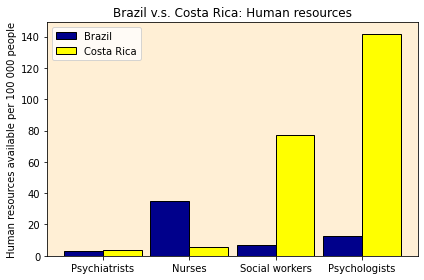

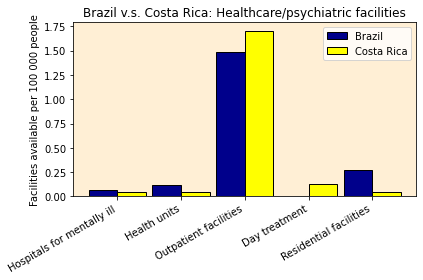

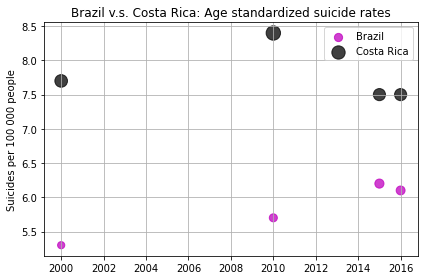

In [234]:
seeTwoCountries('Brazil', 'Costa Rica')

Part 2 Setup

In [286]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/enanpurrp/MHIT/main/who_suicide_statistics.csv')
raw_data.dropna(inplace=True)

def buildModelandPredict(country, year, sex, age, population):
  y = raw_data.suicides_no
  features = ['country', 'year', 'sex', 'age', 'population']
  X = raw_data[features]

  raw_data[]

  train_X, val_X, train_y, val_y = train_test_split(X, y)

  # Encoding categorical variables
  cat_cols = ['country', 'sex', 'age']

  label_X_train = train_X.copy()
  label_X_val = val_X.copy()
  label_y_train = train_y.copy()
  label_y_val = val_y.copy()

  LE = LabelEncoder()
  for col in cat_cols:
    label_X_train[col] = LE.fit_transform(train_X[col])
    label_X_val[col] = LE.transform(val_X[col])

  # Cleaning up & imputing missing values
  imputer = SimpleImputer(add_indicator=True)
  imputed_X_train = pd.DataFrame(imputer.fit_transform(label_X_train))
  imputed_X_val = pd.DataFrame(imputer.transform(label_X_val))
  imputed_X_train.columns = train_X.columns
  imputed_X_val.columns = val_X.columns

  # Defining the models - default parameters works best for some reason
  rf_model = RandomForestRegressor()
  rf_model.fit(imputed_X_train, train_y)
  rf_val_predictions = rf_model.predict(imputed_X_val)


# Loss function
mae_rf = mean_absolute_error(rf_val_predictions, val_y)

# got about 22
# standard deviation of val_Y is 843, so the model is decently accurate

Predicting trends in suicide rates across the world beyond 2020



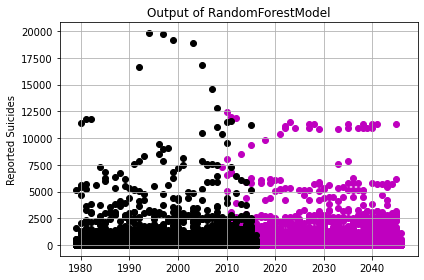

In [311]:
future_X = imputed_X_val.copy()
future_X['year'] += 30
future_X['population'] *= 1.25
  # takes 63 years for population to double at current rate
  # so in 30 years ~ 125% of population

rf_future_predictions = rf_model.predict(future_X)

fig4, ax4 = plt.subplots()
ax4.scatter(future_X['year'], rf_future_predictions, c='m')
ax4.scatter(imputed_X_val['year'], rf_val_predictions, c='k')

ax4.set_ylabel('Reported Suicides')
ax4.set_title('Output of RandomForestModel')
ax4.grid(True)

fig4.tight_layout()

plt.show()